In [98]:
import numpy as np
from scipy import misc
from matplotlib import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

def get_data(filename):
    labels, data = [], []

    for line in open(filename):
        im = misc.imread(line.strip().split()[0])
        data.append(im.reshape(2500,))
        labels.append(line.strip().split()[1])
    return (np.array(data, dtype=float), np.array(labels, dtype=int))

((540L, 2500L), (540L,))


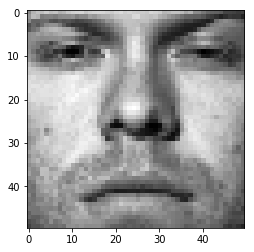

In [99]:
"""
Part 1.B
"""
train_data, train_labels = [], []
train_data, train_labels = get_data('./faces/train.txt')
    
print(train_data.shape, train_labels.shape)
plt.imshow(train_data[10, :].reshape(50,50), cmap=cm.Greys_r)

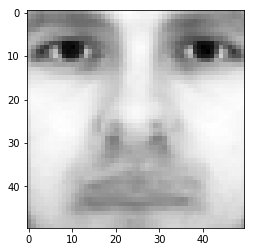

In [100]:
"""
Part 1.C
"""
training_avg = np.zeros(len(train_data[0]))
for td in train_data: training_avg += td
training_avg /= len(train_data)

plt.clf()
plt.imshow(training_avg.reshape(50,50), cmap=cm.Greys_r)

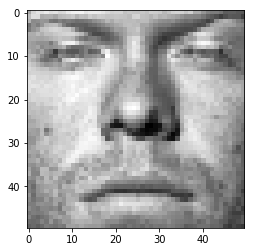

In [101]:
"""
Part 1.D - training set
"""
for i in range(len(train_data)): train_data[i] -= training_avg

plt.clf()
plt.imshow(train_data[10].reshape(50,50), cmap=cm.Greys_r)

(100L, 2500L)


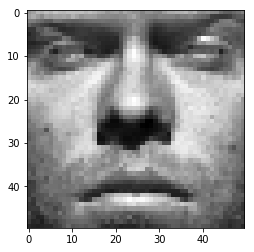

In [102]:
"""
Part 1.D - testing set
"""
test_data, test_labels = get_data('./faces/test.txt')
print(test_data.shape)
for i in range(len(test_data)): test_data[i] -= training_avg
  
plt.clf()
plt.imshow(test_data[0].reshape(50,50), cmap=cm.Greys_r)

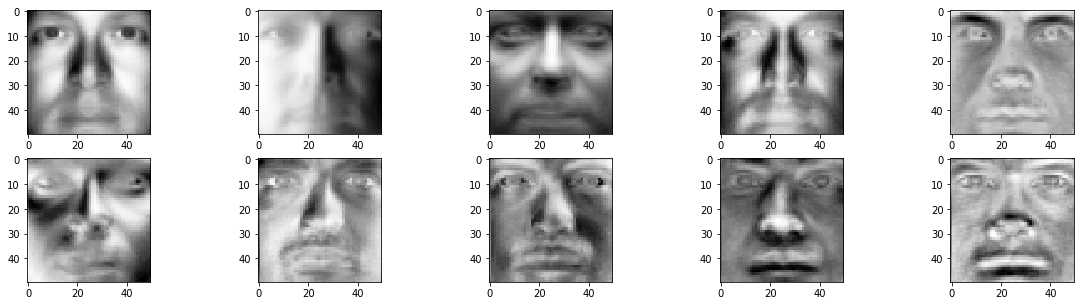

In [103]:
"""
Part 1.E
"""
from numpy.linalg import svd
U, E, Vt = svd(train_data, full_matrices=True)
U_test, E_test, Vt_test = svd(test_data, full_matrices=True)
E = np.diag(E)
E_test = np.diag(E_test)

plt.clf()
f, axarr = plt.subplots(2,5,figsize=(20,5))
for cols in range(5):
    for rows in range(2):
        axarr[rows, cols].imshow(Vt[rows*5 + cols].reshape(50,50), cmap=cm.Greys_r)


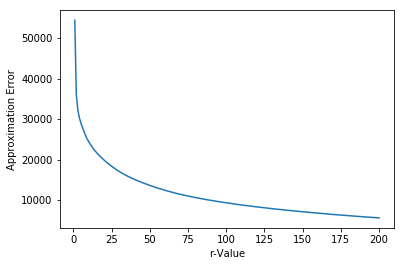

In [104]:
"""
Part 1.F
"""
x_axis = [i for i in range(1, 201)]
dist = []
for r in range(1,201):
    x_hat = U[:,:r].dot(E[:r,:r].dot(Vt[:r,:]))
    d = np.linalg.norm(train_data - x_hat, ord='fro')
    dist.append(d)

plt.clf()
plt.xlabel('r-Value')
plt.ylabel('Approximation Error')
plt.plot(x_axis, dist)

In [105]:
"""
Part 1.G
"""
def get_F(r, data, V_t):
    return data.dot(np.transpose(V_t[:r,:]))

F_train_10 = get_F(10, train_data, Vt)
F_test_10 = get_F(10, test_data, Vt_test)

Score with r=10: 0.23


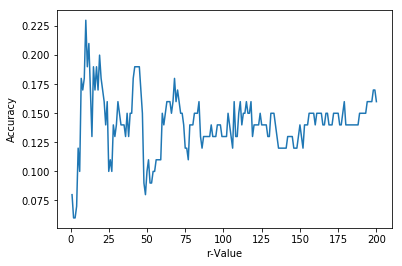

In [106]:
"""
Part 1.F
"""
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(multi_class='ovr')
model.fit(F_train_10, train_labels)
preds = model.predict(F_test_10)
score = accuracy_score(test_labels, preds)
print('Score with r=10: {0}'.format(score))

scores = []
for r in range(1, 201):
    F_train = get_F(r, train_data, Vt)
    F_test = get_F(r, test_data, Vt_test)
    
    model = LogisticRegression(multi_class='ovr')
    model.fit(F_train, train_labels)
    preds = model.predict(F_test)
    scores.append(accuracy_score(test_labels, preds))

plt.clf()
plt.xlabel('r-Value')
plt.ylabel('Accuracy')
plt.plot(x_axis, scores)

In [118]:
"""
Part 2.C
"""
import json
ingredients_list = {} # map ingredients to a vector point
def get_cooking_data(filename):
    with open(filename) as f:
        return json.load(f)

def vectorize_data(j_data):
    r_data = []
    r_labels = []
    ids = []
    for d in j_data:
        vec = np.zeros(len(ingredients_list))
        ids.append(d['id'])
        if 'cuisine' in d:
            lab = d['cuisine']
            r_labels.append(lab)
        for i in d['ingredients']:
            vec[ingredients_list[i]] = 1
        r_data.append(vec)
    return np.array(ids), np.array(r_data), np.array(r_labels)

def get_ingredients_vector(train_data, test_data):
    for d in train_data:
        for i in d['ingredients']:
            if i not in ingredients_list:
                ingredients_list[i] = len(ingredients_list)

    for d in test_data:
        for i in d['ingredients']:
            if i not in ingredients_list:
                ingredients_list[i] = len(ingredients_list)
    print(len(ingredients_list))

tr_data = get_cooking_data('./cooking_data/train.json')
te_data = get_cooking_data('./cooking_data/test.json')
get_ingredients_vector(tr_data, te_data)
training_ids, training_data, training_labels = vectorize_data(tr_data)
test_ids, test_data, _ = vectorize_data(te_data)

7137


In [119]:
"""
Part 2.D
"""
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.model_selection import cross_val_score

g_nb = GaussianNB()
b_nb = BernoulliNB()

g_scores = cross_val_score(g_nb, training_data, training_labels, cv=3)
b_scores = cross_val_score(b_nb, training_data, training_labels, cv=3)

print('Gaussian 3-fold cross validation score: ' + str(sum(g_scores) / len(g_scores)))
print('Bernoulli 3-fold cross validation score: ' + str(sum(b_scores) / len(b_scores)))

Gaussian 3-fold cross validation score: 0.379493793821
Bernoulli 3-fold cross validation score: 0.678408428328


In [120]:
"""
Part 2.F
"""
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr_scores = cross_val_score(lr, training_data, training_labels, cv=3)
print('Logistic Regression 3-fold cross validation score: ' + str(sum(lr_scores)/len(lr_scores)))

Logistic Regression 3-fold cross validation score: 0.775758670409


In [137]:
"""
Part 2.G
"""
import csv
def write_outputs(ids, labels):
    with open('testing_output.csv', 'wb') as tof:
        writer = csv.writer(tof, delimiter=',')
        
        writer.writerow(['id', 'cuisine'])
        for i in range(len(ids)):
            c_id = ids[i]
            l = labels[i]
            writer.writerow([c_id, l])

lr = LogisticRegression().fit(training_data, training_labels)
preds = lr.predict(test_data)

write_outputs(test_ids, preds)